# Image Processing
This lesson will go over how to work with image data, extract information, and perform basic operations and transformations on images.

We'll be using primarily the [Pillow](https://pillow.readthedocs.io/en/stable/index.html) and [opencv](https://opencv.org/) libraries.

Pillow is a fork of the older, no-longer maintained PIL (python imaging library) package. It provides base classes for representing image data, and some convenience helper functions and dictionaries.

OpenCV is a powerful image processing library. It is originally a C++ library, but we will be using the python bindings to call it in python. One important quirk of OpenCV is that **it represents image channels in BGR**, i.e. the first channel is Blue, whereas most other image representations (including PIL) use RGB, where the first channel is Red. Thus, you must make sure to switch up the order of channels when converting between PIL and opencv
(_The reason that opencv uses BGR is that old windows systems used to represent images in BGR, and when opencv was created, they followed that convention_)

In [1]:
import PIL # Python Image Library (pillow)
from PIL.ExifTags import TAGS, GPSTAGS # dictionaries for exiftags and gpstags names
import cv2
import pathlib # standard library package for working with file paths
import numpy as np
from matplotlib import pyplot as plt

## Import images

In [2]:
!wget https://files.bwsi-remote-sensing.net/data/photos/BWSI-2019-MATF1-photos.zip -O photos.zip

--2024-07-26 19:40:09--  https://files.bwsi-remote-sensing.net/data/photos/BWSI-2019-MATF1-photos.zip
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 44.234.198.52, 44.239.244.82, 52.39.175.7, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|44.234.198.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 609589187 (581M) [application/zip]
Saving to: ‘photos.zip’

photos.zip          100%[===================>] 581.35M   185MB/s    in 3.2s    

2024-07-26 19:40:12 (183 MB/s) - ‘photos.zip’ saved [609589187/609589187]



In [3]:
# !unzip -o photos.zip

In [4]:
# create a pathlib Path object
# pathlib provides functions that make it easier to operate with file paths
image_folder = pathlib.Path('BWSI-2019-MATF1-photos/')

In [5]:
# iterdir gives an iterator for all of the items within a pathlib Path directory
# get list of files that are jpg or png
compatible_imgs = [x for x in image_folder.iterdir() 
                   if ((x.suffix.lower() == '.jpg') 
                       or (x.suffix.lower() == '.png'))]

#Not case sensitive
compatible_imgs

[PosixPath('BWSI-2019-MATF1-photos/IMG_0703.jpg'),
 PosixPath('BWSI-2019-MATF1-photos/IMG_0700.jpg'),
 PosixPath('BWSI-2019-MATF1-photos/IMG_0461.JPG'),
 PosixPath('BWSI-2019-MATF1-photos/20190717_142402.jpg'),
 PosixPath('BWSI-2019-MATF1-photos/20190717_142301.jpg'),
 PosixPath('BWSI-2019-MATF1-photos/IMG_0715.jpg'),
 PosixPath('BWSI-2019-MATF1-photos/20190717_142158.jpg'),
 PosixPath('BWSI-2019-MATF1-photos/IMG_0475.JPG'),
 PosixPath('BWSI-2019-MATF1-photos/IMG_0463.JPG'),
 PosixPath('BWSI-2019-MATF1-photos/IMG_0477.JPG'),
 PosixPath('BWSI-2019-MATF1-photos/20190717_142652.jpg'),
 PosixPath('BWSI-2019-MATF1-photos/IMG_0470.JPG'),
 PosixPath('BWSI-2019-MATF1-photos/IMG_20190717_140538117_HDR.jpg'),
 PosixPath('BWSI-2019-MATF1-photos/IMG_0469.JPG'),
 PosixPath('BWSI-2019-MATF1-photos/IMG_20190717_141320115.jpg'),
 PosixPath('BWSI-2019-MATF1-photos/20190717_142416.jpg'),
 PosixPath('BWSI-2019-MATF1-photos/IMG_0710.jpg'),
 PosixPath('BWSI-2019-MATF1-photos/20190717_142737.jpg'),
 PosixPa

In [ ]:
random_image_path = np.random.choice(compatible_imgs)
random_img = PIL.Image.open(random_image_path)
print(random_image_path)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(random_img)
plt.show()

BWSI-2019-MATF1-photos/20190717_142456.jpg


In [ ]:
random_img_exif = random_img._getexif()
random_img_exif #No metadata so will add some

## Parsing EXIF
The dictionary has numeric codes for keys. For human readability, it's convenient to use the text descriptions as the keys.

There are a few lookup dictionaries that can be used to find the text descriptions. We've imported them as TAGS and GPSTAGS

In [ ]:
TAGS

In [ ]:
GPSTAGS

In [ ]:
# here's some functions to parse the exif data and convert them to decimal format
def parse_exif(exif_dict):
    human_readable = {}
    for k, v in exif_dict.items():
        text_key = TAGS[k]
        if type(v) == tuple and len(v)==2:
            v = divide_tuple(v)
        if type(v) == bytes:
            v = v.hex()
        if k == 34853: # GPS info field
            human_readable[text_key] = parse_gps(v)
        elif not ((text_key == 'UserComment') or (text_key == 'MakerNote')):
            human_readable[text_key] = v
    return human_readable
      
def parse_gps(gps_dict):
    readable_gps = {}
    for k,v in gps_dict.items():
        text_key = GPSTAGS[k]
        if text_key in ['GPSLatitude', 'GPSLongitude']:
            print(v)
            v = convert_GPS_coord(v)
        if type(v) == bytes:
            v = v.hex()
        readable_gps[text_key] = v
    return readable_gps

def divide_tuple(tup):
    try:
        quot = tup[0]/tup[1]
        return quot
    except:
        return None

def convert_GPS_coord(GPS_tuple):
    """ Converts the GPS coordinate given by exif into decimal coord
    GPS_Tuple = (
       degrees, minutes, seconds
       )
    """
    try:
        degs = float(GPS_tuple[0])
        mins = float(GPS_tuple[1])
        secs = float(GPS_tuple[2])
        return degs + mins/60 + secs/3600
    except:
        return None


In [ ]:
parsed = parse_exif(random_img_exif) 
parsed

In [ ]:
for img_path in compatible_imgs:
    img = PIL.Image.open(img_path)
    exif = parse_exif(img._getexif())
    if 'GPSInfo' in exif.keys():
        print(img_path)
        print(exif['GPSInfo'])

## Exercise
Create a dataframe that holds the metadata of the images in the course folder. You do not need to store all of the metadata fields, just the ones that you may be interested in.

Note that not all images will have all of the EXIF fields filled out, so you will have entries with blank or placeholder values in certain columns.

Note also that the GPSInfo element of EXIF is a dictionary in and of itself. Be cognizant of this when trying to access those attributes. For example, you cannot get exif_info['GPSLatitude'] directly. You have to get it as exif_info['GPSInfo']['GPSLatitude']

In [ ]:
import pandas as pd
# Extract metadata from the images and create a dataframe
def extract_exif_data(img_path):
    image = PIL.Image.open(img_path)
    exif_data = image._getexif()
    exif = {}
    if exif_data:
        # this keeps all the tags, but alter it to choose which tags you want to keep
        for tag, value in exif_data.items():
            tag_name = TAGS.get(tag, tag)
            exif[tag_name] = value
            if tag_name == "GPSInfo":
                gps_data = {}
                for gps_tag in value:
                    gps_tag_name = GPSTAGS.get(gps_tag, gps_tag)
                    gps_data[gps_tag_name] = value[gps_tag]
                exif[tag_name] = gps_data
    return exif

# Loop through the images
metadata_list = []
for img_path in compatible_imgs:
    exif = extract_exif_data(img_path)
    exif['ImageFile'] = img_path.name
    metadata_list.append(exif)


# Create a dataframe from the metadata
df = pd.DataFrame(metadata_list)

df.head()

## Image Processing

## Color Spaces
Colors can be represented as a multi-dimensional space. One common way of representing colors is with RGB values. One can think of RGB as a 3d Cartesian coordinate system, where the R, G, and B values represent the x, y, and z coordinates respectively. A wide array of colors can then be expressed as tuples in this RGB space.

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/RGB_Cube_Show_lowgamma_cutout_a.png/400px-RGB_Cube_Show_lowgamma_cutout_a.png)

In [ ]:
# Get raw image
raw_img = cv2.imread(str(random_image_path),-1)
# Convert to lower resolution for analysis speedup
lowres_dim = 1800
img_shape = raw_img.shape
img = cv2.resize(raw_img,
                (int((img_shape[1]/img_shape[0])*lowres_dim), lowres_dim ),
                interpolation=cv2.INTER_CUBIC)



In [ ]:
# colors look weird if you use imshow on the regular cv image
# this is because it's in BGR instead of RGB
plt.figure(figsize=[10,10])
plt.imshow(img, interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

#For scaling, make use of neighboring pixel

In [ ]:
# Convert to different color spaces from BGR (cv convention vs. plt convention)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
grey_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
HSV_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

In [ ]:
# correct color space
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
ax.imshow(RGB_img)
ax.set_axis_off()

In [ ]:
# Show the RGB color channels
red_channel = RGB_img[:,:,0]
green_channel = RGB_img[:,:,1]
blue_channel = RGB_img[:,:,2]
fig = plt.figure(figsize=[10,15])
ax1 = fig.add_subplot(3,1,1)
ax1.imshow(red_channel,cmap='Reds')
ax1.set_axis_off()
ax2 = fig.add_subplot(3,1,2)
ax2.imshow(green_channel,cmap='Greens')
ax2.set_axis_off()
ax3 = fig.add_subplot(3,1,3)
ax3.imshow(blue_channel,cmap='Blues')
ax3.set_axis_off()
plt.tight_layout()

In [ ]:
# visualizing histograms
fig = plt.figure()
ax1 = fig.add_subplot(3,1,1)
ax1.hist(red_channel.flatten(),256,[0,256], color = 'r')
ax2 = fig.add_subplot(3,1,2)
ax2.hist(green_channel.flatten(),256,[0,256], color = 'g')
ax3 = fig.add_subplot(3,1,3)
ax3.hist(blue_channel.flatten(),256,[0,256], color = 'b')
plt.show()

#X is intensity of color (make is 255)
#Y is the number of pixel

### Other color spaces
Much like how space can be represented both using cartesian coordinates and other coordinate systems, color spaces can be represented with other coordinates as well.

One such alternative is the hue, saturation, value (HSV) system, which can be thought of as a cylindrical coordinate system.
- Hue represents the color (low=violet, high=red)
- Saturation represents the color intensity (low=grey, high=colorful)
- Value represents brightness (low=black, high=white)

![alt text](https://upload.wikimedia.org/wikipedia/commons/3/33/HSV_color_solid_cylinder_saturation_gray.png)

## Checkpoint
For each line of the following lines, explain what is happening using comments.

In [ ]:
hue_channel = HSV_img[:,:,0]
saturation_channel = HSV_img[:,:,1]
value_channel = HSV_img[:,:,2]
fig = plt.figure(figsize=[10,15])
ax1 = fig.add_subplot(3,1,1)
ax1.imshow(hue_channel,cmap='Greys_r')
ax1.set_axis_off()
ax1.set_title('hue')
ax2 = fig.add_subplot(3,1,2)
ax2.imshow(saturation_channel,cmap='Greys_r')
ax2.set_axis_off()
ax2.set_title('saturation')
ax3 = fig.add_subplot(3,1,3)
ax3.imshow(value_channel,cmap='Greys_r')
ax3.set_axis_off()
ax3.set_title('value')
plt.tight_layout()

#Plotting Hue, Saturation, & Value

pyplot's imshow assumes that the first channel is red, the second is green, and the last is blue. Thus, we can present other information in the R, G, B channels. For example, we can plot the HSV channels in the RGB channels to get a trippy picture

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.imshow(HSV_img)# hue -> red, saturation -> green, value -> blue

# Convolution filters
The process of convolution involves taking the dot product between a "kernel" matrix and subsets of a matrix centered at various points across the image, and storing the result of the matrix multiplication in a new matrix as the result of the operation.

![convolution_example](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)

Different types of kernels result in different types of outputs. 
For this input image:

![input image](https://upload.wikimedia.org/wikipedia/commons/5/50/Vd-Orig.png)

Here are some types of kernels that can be applied and their effects

### Identity
![identity kernel](https://wikimedia.org/api/rest_v1/media/math/render/svg/1fbc763a0af339e3a3ff20af60a8a993c53086a7)

![input image](https://upload.wikimedia.org/wikipedia/commons/5/50/Vd-Orig.png)
### Edge detection
![edge_kernel](https://wikimedia.org/api/rest_v1/media/math/render/svg/f9de5913c98629f30efb20b8868e096f202b626c)

![edge_result](https://upload.wikimedia.org/wikipedia/commons/2/20/Vd-Rige1.png)
### Sharpen
![sharpen_kernel](https://wikimedia.org/api/rest_v1/media/math/render/svg/beb8b9a493e8b9cf5deccd61bd845a59ea2e62cc)

![sharpen_result](https://upload.wikimedia.org/wikipedia/commons/4/4e/Vd-Sharp.png)
### Box Blur 
![box_blur_kernel](https://wikimedia.org/api/rest_v1/media/math/render/svg/91256bfeece3344f8602e288d445e6422c8b8a1c)

![box blur result](https://upload.wikimedia.org/wikipedia/commons/0/04/Vd-Blur2.png)
### Gaussian blur (3x3) 
![gauss kernel 3x3](https://wikimedia.org/api/rest_v1/media/math/render/svg/ca9c0da52fe7818783942b06aac9cf396ae628bf)

![gauss result 3x3](https://upload.wikimedia.org/wikipedia/commons/2/28/Vd-Blur1.png)
### Gaussian blur (5x5) 
![gauss kernel 5x5](https://wikimedia.org/api/rest_v1/media/math/render/svg/f91401a3e97428f14862afa1c781c55f4157580b)

![gauss result 5x5](https://upload.wikimedia.org/wikipedia/commons/0/04/Vd-Blur_Gaussian_5x5.png)

## Convolution Terminology
- kernel size: the dimensions of the kernel matrix
- stride: how many elements you move over each time you slide the window
- padding: how do you deal with the values at the boundary when the kernel "overhangs" the original matrix
    - some strategies: pad with fixed value (often zero), reflect, wrap, only use valid convolutions

### OpenCV convolution support
OpenCV supports convolutions with arbitrary convolution kernels via the [`filter2D()` function](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04)

Some common convolutions also have dedicated functions for convenience, such as [box blur](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga8c45db9afe636703801b0b2e440fce37), and [gaussian blur](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gaabe8c836e97159a9193fb0b11ac52cf1)

In [ ]:
# general convolution
# create kernel
#Typically break from uneven side length kernels
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
# the -1 argument for ddepth in filter2D preserves number of layers in output
sharpened_img = cv2.filter2D(RGB_img, -1, sharpen_kernel) 

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
ax.imshow(RGB_img)
ax.set_axis_off()
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(sharpened_img)
ax2.set_axis_off()
fig.tight_layout()


In [ ]:
# example for gaussian blur
gauss_blur_kernel_size = (13,13)
gauss_blur_kernel_sigma = 19
blurred_RGB_img = cv2.GaussianBlur(RGB_img,
                                   gauss_blur_kernel_size,
                                   gauss_blur_kernel_sigma)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
ax.imshow(RGB_img)
ax.set_axis_off()
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(blurred_RGB_img)
ax2.set_axis_off()
fig.tight_layout()

#If you do 3,3 (1,3,2) by 15 by 15 (15,15) you see a very blurred pic difference
#Create a Unique result of these images

In [ ]:
# example for gaussian blur
gauss_blur_kernel_size = (13,13)
gauss_blur_kernel_sigma = 19
blurred_RGB_img = cv2.GaussianBlur(RGB_img,
                                   gauss_blur_kernel_size,
                                   gauss_blur_kernel_sigma)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
ax.imshow(RGB_img)
ax.set_axis_off()
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(blurred_RGB_img)
ax2.set_axis_off()
fig.tight_layout()

#If you do 3,3 (1,3,2) by 15 by 15 (15,15) you see a very blurred pic difference
#Create a Unique result of these images

## Thresholding
Thresholding allows you to convert pixel values that are above/below a threshold to 0 or 1.

There are a ton of different [thresholding schemes](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html).

There are simple thresholding schemes:
 - cv2.THRESH_BINARY
 - cv2.THRESH_BINARY_INV
 - cv2.THRESH_TRUNC
 - cv2.THRESH_TOZERO
 - cv2.THRESH_TOZERO_INV

![thresholding_simple](https://docs.opencv.org/3.0-beta/_images/threshold.jpg)

In [ ]:
# original image in greyscale
plt.imshow(grey_img, cmap='Greys_r')

In [ ]:
# let's try a simple thresholding
# values from 128-255 get converted to 255
# values below 128 get converted to zero


In [ ]:
grey_thresh

### Adaptive thresholding
Simple threshold manually sets the threshold point. There are a number of adaptive methods which use the values of the other pixels to determine the threshold.

There are two available adaptive thresholds:
- cv2.ADAPTIVE_THRESH_MEAN_C : threshold value is the mean of neighbourhood area.
- cv2.ADAPTIVE_THRESH_GAUSSIAN_C : threshold value is the weighted sum of neighbourhood values where weights are a gaussian window.

These take two additional arguments:
- neighborhood: the number of pixels to use to compute the mean or gaussian
- c: a constant that's subtracted from the window

These can be tuned to adjust performance

In [ ]:
# using mean
grey_thresh = cv2.adaptiveThreshold(grey_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                   cv2.THRESH_BINARY, 301, 5)
plt.imshow(grey_thresh, cmap='Greys_r')

In [ ]:
# using gaussian
grey_thresh = cv2.adaptiveThreshold(grey_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY, 501, 10)
plt.imshow(grey_thresh, cmap='Greys_r')

In [ ]:
ret, grey_thresh = cv2.threshold(grey_img, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(grey_thresh, cmap='Greys_r')

In [ ]:
grey_thresh

In [ ]:
# first applying a gaussian blur can reduce noise in the threshold
blurred_img = cv2.GaussianBlur(grey_img,(5,5),0)
plt.imshow(blurred_img, cmap='Greys_r')

In [ ]:
# this reduces some of the noise
ret, grey_thresh = cv2.threshold(blurred_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(grey_thresh, cmap='Greys_r')

## Edge detection

In [ ]:
def get_edges(img):
    # Blur for lowpass
    img = cv2.GaussianBlur(img,(11,11),1)
    # bilat_filt for further noise reduction w/ edge preservation
    img = cv2.bilateralFilter(img,5,20,20)
    # Compute edges
    edges = cv2.Canny(img,30,60)
    return edges

In [ ]:
plt.imshow(get_edges(grey_img),cmap='Greys')

In [ ]:
plt.imshow(get_edges(grey_thresh),cmap='Greys')

In [ ]:
plt.imshow(get_edges(value_channel),cmap='Greys')

## Exercises
Using the image processing techniques learned today, apply them to analyze some satellite or aerial imagery.
For example, you can use thresholding to isolate extent of a fire using the Normalized Burn Ratio index, or get the front of the fire using edge detection.

There are a ton of additional opencv capabilities beyond what we've covered in class. Check the [documentation](https://docs.opencv.org/4.5.2/d6/d00/tutorial_py_root.html) for more ideas!


In [29]:
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
grey_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
HSV_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

In [ ]:
#Filter:
sharpen_kernel = np.array([[0, 1, 0],
                           [1, 1, 1],
                           [0, 1, 0]])
# the -1 argument for ddepth in filter2D preserves number of layers in output
sharpened_img = cv2.filter2D(grey_img, -1, sharpen_kernel) 
def get_edges(img):
    # Blur for lowpass
    img = cv2.GaussianBlur(img,(11,11),1)
    # bilat_filt for further noise reduction w/ edge preservation
    img = cv2.bilateralFilter(img,5,20,20)
    # Compute edges
    edges = cv2.Canny(img,30,60)
    return edges
# plt.imshow(get_edges(sharpened_img))
new_image = get_edges(sharpened_img)
# ret, grey_thresh = cv2.threshold(sharpened_img, 128,255, cv2.THRESH_BINARY)

# fig = plt.figure(figsize=[20,10])
# ax = fig.add_subplot(1,2,1)
# # ax2 = fig.add_subplot(1,2,2)
# ax.imshow(sharpened_img)
# ax.set_axis_off()

# ax2.imshow(grey_img)
# # ax2.set_axis_off()


# ax3.set_axis_off()
# fig.tight_layout()


In [ ]:
!pip install fiona #! means its running as if it was in a terminal
import fiona; fiona.supported_drivers

In [ ]:
import rasterio
import rasterio.plot
import rasterio.merge 
import rasterio.mask
import pyproj
import osmnx as ox
import geopandas as gpd
import pandas as pd
# !pip install fiona
import fiona
from osgeo import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [1]:
import PIL # Python Image Library (pillow)
from PIL.ExifTags import TAGS, GPSTAGS # dictionaries for exiftags and gpstags names
import cv2
import pathlib # standard library package for working with file paths
import numpy as np
from matplotlib import pyplot as plt

In [2]:
image = 'floodGermany.png'

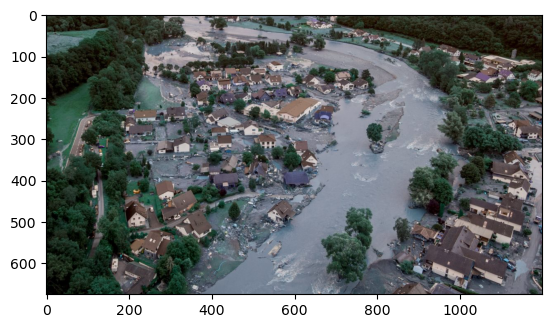

In [3]:
from PIL import Image
img = Image.open(image)
# Display the image
# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(1,1,1)
# ax.imshow(img)
img = np.array(img)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

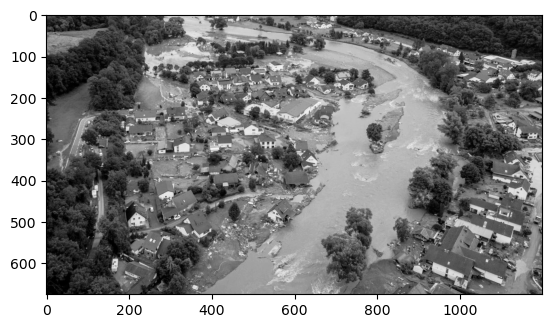

In [4]:
img = np.array(img)
grey_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(grey_img, cmap='Greys_r')

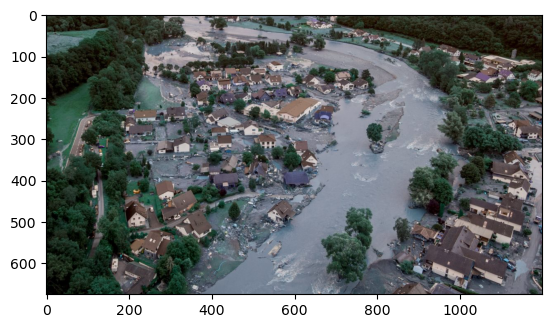

In [30]:
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

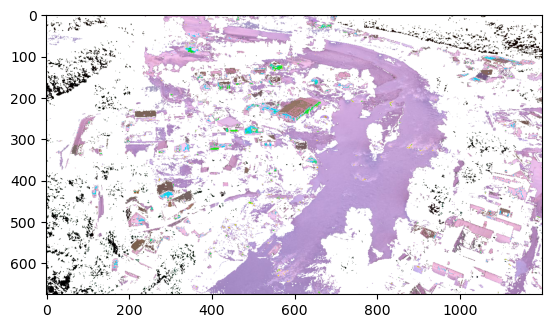

In [29]:
# grey_img = cv2.cvtColor(grey_img,cv2.COLOR_BGR2GRAY)
def water(img):
    #For water______________
    for r, pixel in enumerate(img):
        for c, color in enumerate(pixel):
            red = color[0]
            green = color[1]
            blue = color[2]
            #_______________________________________________________
            if 100< red > 110: #____ For Water
                if 100 < green > 110: 
                    if 100 < blue > 110: 
                        img[r][c] = [red + 50, green + 10,blue + 50]
    return img

plt.imshow(custom_threshold(RGB_img))
# custom_threshold(RGB_img)

In [46]:
#River : grey: m107
#0 is black
#how to get RGB
help(Image)

Help on module PIL.Image in PIL:

NAME
    PIL.Image

DESCRIPTION
    # The Python Imaging Library.
    # $Id$
    #
    # the Image class wrapper
    #
    # partial release history:
    # 1995-09-09 fl   Created
    # 1996-03-11 fl   PIL release 0.0 (proof of concept)
    # 1996-04-30 fl   PIL release 0.1b1
    # 1999-07-28 fl   PIL release 1.0 final
    # 2000-06-07 fl   PIL release 1.1
    # 2000-10-20 fl   PIL release 1.1.1
    # 2001-05-07 fl   PIL release 1.1.2
    # 2002-03-15 fl   PIL release 1.1.3
    # 2003-05-10 fl   PIL release 1.1.4
    # 2005-03-28 fl   PIL release 1.1.5
    # 2006-12-02 fl   PIL release 1.1.6
    # 2009-11-15 fl   PIL release 1.1.7
    #
    # Copyright (c) 1997-2009 by Secret Labs AB.  All rights reserved.
    # Copyright (c) 1995-2009 by Fredrik Lundh.
    #
    # See the README file for information on usage and redistribution.
    #

CLASSES
    builtins.Exception(builtins.BaseException)
        DecompressionBombError
    builtins.RuntimeWarning(buil

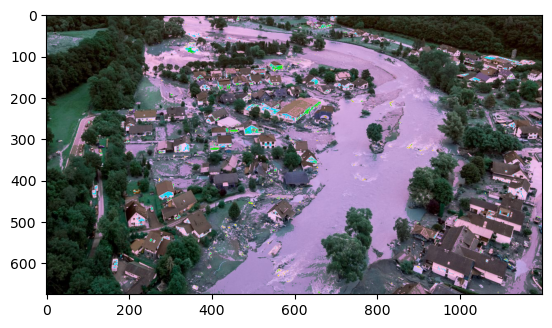

In [35]:
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
def custom_threshold(img):
    for r, pixel in enumerate(img):
        for c, color in enumerate(pixel):
            red = color[0]
            green = color[1]
            blue = color[2]

            if 100 < red > 110:
              if 100< blue > 110:
                if 100< green > 110:
                        img[r][c] = [red + 50, green + 10, blue + 50]
    return img

plt.imshow(custom_threshold(RGB_img))
